# Research Pipeline with Custom Fundamental Data

This notebook demonstrates quantitative research and stock screening using **existing** custom fundamental data.

**Prerequisites**: 
- Run `load_csv_fundamentals.ipynb` **first** to create the database
- Ensure database exists at `~/.zipline/data/custom/fundamentals.sqlite`

## What You'll Learn

1. **Pipeline Basics**: Creating DataSets from your custom data
2. **Factor Analysis**: Building factors from fundamental metrics  
3. **Screening**: Filtering stocks based on fundamental criteria
4. **Ranking**: Scoring and ranking stocks for investment decisions
5. **Integration**: Combining fundamentals with price data
6. **Visualization**: Analyzing results with charts
7. **Time Series**: Tracking fundamental trends over time

## Use Cases

- **Value Investing**: Screen for low P/E, high ROE stocks
- **Quality Analysis**: Identify companies with strong fundamentals  
- **Sector Rotation**: Compare metrics across sectors
- **Factor Research**: Test custom factors based on fundamentals
- **Portfolio Construction**: Build portfolios using fundamental signals

---

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import Zipline custom data module
from zipline.data.custom import (
    describe_custom_db,
    list_custom_dbs,
    get_prices,
    get_latest_values,
    make_custom_dataset_class,
)

# Import Zipline Pipeline
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import EquityPricing

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Imports successful!")

✓ Imports successful!


In [2]:
# Database configuration
DB_CODE = 'fundamentals'  # Must match the database created in load_csv_fundamentals.ipynb

# Check that database exists
available_dbs = list_custom_dbs()

if DB_CODE not in available_dbs:
    print("❌ ERROR: Database not found!")
    print(f"\nExpected database: '{DB_CODE}'")
    print(f"Available databases: {available_dbs}")
    print("\n⚠️  Please run 'load_csv_fundamentals.ipynb' first to create the database.")
    raise FileNotFoundError(f"Database '{DB_CODE}' not found. Run load_csv_fundamentals.ipynb first.")
else:
    print(f"✓ Database '{DB_CODE}' found!")
    
    # Get database info
    db_info = describe_custom_db(DB_CODE)
    
    print(f"\nDatabase Statistics:")
    print(f"  Location: {db_info['db_path']}")
    print(f"  Total rows: {db_info['row_count']:,}")
    print(f"  Unique assets: {db_info['num_sids']}")
    if db_info['date_range']:
        print(f"  Date range: {db_info['date_range'][0]} to {db_info['date_range'][1]}")
    print(f"  Columns: {len(db_info['columns'])}")

✓ Database 'fundamentals' found!

Database Statistics:
  Location: /data/custom_databases/fundamentals.sqlite
  Total rows: 44
  Unique assets: 11
  Date range: 2023-03-31 00:00:00 to 2024-01-31 00:00:00
  Columns: 12


In [3]:
# Define schema for reference (should match what's in the database)
fundamental_columns = {
    # Symbol (important!)
    'Symbol': 'text',
    
    # Income Statement
    'Revenue': 'int',
    'NetIncome': 'int',
    
    # Balance Sheet  
    'TotalAssets': 'int',
    'TotalEquity': 'int',
    'SharesOutstanding': 'int',
    
    # Per-Share Metrics
    'EPS': 'float',
    'BookValuePerShare': 'float',
    
    # Financial Ratios
    'ROE': 'float',
    'DebtToEquity': 'float', 
    'CurrentRatio': 'float',
    'PERatio': 'float',
    
    # Metadata
    'Sector': 'text',
}

print(f"Schema defined with {len(fundamental_columns)} columns")
print("\nNote: This should match the database created in load_csv_fundamentals.ipynb")
print("Important: Symbol column must be included to get ticker labels in charts!")

Schema defined with 13 columns

Note: This should match the database created in load_csv_fundamentals.ipynb
Important: Symbol column must be included to get ticker labels in charts!


In [4]:
# Helper function to get data including Symbol column
# Works with both simple and LSEG database schemas

import sqlite3
from zipline.data.custom import get_db_path

def get_fundamentals_with_symbol(db_code, as_of_date, sids=None):
    """
    Get fundamental data including Symbol column.
    Automatically maps LSEG column names to standard names.
    
    Parameters
    ----------
    db_code : str
        Database code
    as_of_date : str
        Date in 'YYYY-MM-DD' format
    sids : list of str, optional
        List of SIDs to query
    
    Returns
    -------
    DataFrame with standardized columns including Symbol
    """
    db_path = get_db_path(db_code)
    conn = sqlite3.connect(str(db_path))
    
    # Build query to get latest data for each SID
    if sids:
        sid_placeholders = ','.join(['?' for _ in sids])
        query = f"""
        SELECT p1.*
        FROM Price p1
        WHERE p1.Date = (
            SELECT MAX(p2.Date)
            FROM Price p2
            WHERE p2.Sid = p1.Sid
            AND p2.Date <= ?
            AND p2.Sid IN ({sid_placeholders})
        )
        AND p1.Sid IN ({sid_placeholders})
        """
        params = [as_of_date] + sids + sids
    else:
        query = """
        SELECT p1.*
        FROM Price p1
        WHERE p1.Date = (
            SELECT MAX(p2.Date)
            FROM Price p2
            WHERE p2.Sid = p1.Sid
            AND p2.Date <= ?
        )
        """
        params = [as_of_date]
    
    df = pd.read_sql(query, conn, params=params)
    conn.close()
    
    # Map LSEG column names to standard names for compatibility
    column_mapping = {
        'ReturnOnEquity_SmartEstimat': 'ROE',
        'ForwardPEG_DailyTimeSeriesRatio_': 'PERatio',
        'Debt_Total': 'DebtToEquity',  # Note: This is debt, not debt/equity ratio
        'EarningsPerShare_Actual': 'EPS',
        'GICSSectorName': 'Sector',
        'CompanyMarketCap': 'MarketCap',
        'FOCFExDividends_Discrete': 'Revenue',  # Approximation
        'CompanyCommonName': 'CompanyName',
    }
    
    # Rename columns that exist
    for old_name, new_name in column_mapping.items():
        if old_name in df.columns and new_name not in df.columns:
            df[new_name] = df[old_name]
    
    # Add CurrentRatio if not present (placeholder)
    if 'CurrentRatio' not in df.columns:
        df['CurrentRatio'] = 1.5  # Default value
    
    return df

print("✓ Helper function defined: get_fundamentals_with_symbol()")
print("  Automatically maps LSEG column names to standard names")
print("  Includes Symbol column from database")

✓ Helper function defined: get_fundamentals_with_symbol()
  This function queries the database directly to include Symbol column


---

## Part 3: Create Pipeline DataSet

Now we'll create a Zipline Pipeline DataSet from our custom data. This allows us to use the data in Pipeline computations.

In [5]:
# Create a DataSet class from our database
CustomFundamentals = make_custom_dataset_class(
    db_code=DB_CODE,
    columns=fundamental_columns,
    base_name='CustomFundamentals',  # This will create 'FundamentalsDataSet'
)

print("✓ DataSet class created: FundamentalsDataSet")
print("\nAvailable columns (as Pipeline factors):")
for col in fundamental_columns.keys():
    print(f"  - CustomFundamentals.{col}")
    
print("\nYou can now use these in Pipeline like:")
print("  CustomFundamentals.Revenue.latest")
print("  CustomFundamentals.ROE.latest")
print("  CustomFundamentals.PERatio.latest")

✓ DataSet class created: FundamentalsDataSet

Available columns (as Pipeline factors):
  - CustomFundamentals.Symbol
  - CustomFundamentals.Revenue
  - CustomFundamentals.NetIncome
  - CustomFundamentals.TotalAssets
  - CustomFundamentals.TotalEquity
  - CustomFundamentals.SharesOutstanding
  - CustomFundamentals.EPS
  - CustomFundamentals.BookValuePerShare
  - CustomFundamentals.ROE
  - CustomFundamentals.DebtToEquity
  - CustomFundamentals.CurrentRatio
  - CustomFundamentals.PERatio
  - CustomFundamentals.Sector

You can now use these in Pipeline like:
  CustomFundamentals.Revenue.latest
  CustomFundamentals.ROE.latest
  CustomFundamentals.PERatio.latest


---

## Part 4: Simple Pipeline Examples

Let's create some simple pipelines to screen and rank stocks.

### Example 1: Basic Screening

Screen for stocks with:
- High ROE (> 10%)
- Low P/E ratio (< 30)
- Low debt (Debt/Equity < 1.0)

In [6]:
# Create a simple screening pipeline
def make_screening_pipeline():
    """
    Create a pipeline that screens for quality stocks.
    
    Criteria:
    - ROE > 10% (profitable and efficient)
    - P/E < 30 (reasonably valued)
    - Debt/Equity < 1.0 (not over-leveraged)
    """
    # Get the latest fundamental values
    roe = CustomFundamentals.ROE.latest
    pe_ratio = CustomFundamentals.PERatio.latest
    debt_to_equity = CustomFundamentals.DebtToEquity.latest
    eps = CustomFundamentals.EPS.latest
    revenue = CustomFundamentals.Revenue.latest
    sector = CustomFundamentals.Sector.latest
    
    # Define screening filters
    high_roe = (roe > 10.0)
    reasonable_pe = (pe_ratio < 30.0)
    low_debt = (debt_to_equity < 1.0)
    
    # Combine filters
    quality_screen = high_roe & reasonable_pe & low_debt
    
    # Create pipeline
    return Pipeline(
        columns={
            'ROE': roe,
            'PE_Ratio': pe_ratio,
            'Debt_to_Equity': debt_to_equity,
            'EPS': eps,
            'Revenue': revenue,
            'Sector': sector,
        },
        screen=quality_screen,  # Only return stocks passing the screen
    )

screening_pipeline = make_screening_pipeline()
print("✓ Screening pipeline created")
print("  Filters: ROE > 10%, P/E < 30, Debt/Equity < 1.0")

✓ Screening pipeline created
  Filters: ROE > 10%, P/E < 30, Debt/Equity < 1.0


### Example 2: Ranking Pipeline

Rank stocks by a composite quality score.

In [7]:
# Create a custom factor for quality score
class QualityScore(CustomFactor):
    """
    Composite quality score based on:
    - ROE (higher is better)
    - P/E ratio (lower is better)
    - Debt/Equity (lower is better)
    
    Returns a normalized score where higher = better quality.
    """
    inputs = [
        CustomFundamentals.ROE,
        CustomFundamentals.PERatio,
        CustomFundamentals.DebtToEquity,
    ]
    window_length = 1  # Only need latest value
    
    def compute(self, today, assets, out, roe, pe, debt):
        # Get latest values (window_length=1, use -1 for most recent)
        roe_latest = roe[-1]
        pe_latest = pe[-1]
        debt_latest = debt[-1]
        
        # Normalize each metric to 0-1 scale using min-max normalization
        # ROE: higher is better
        roe_min, roe_max = np.nanmin(roe_latest), np.nanmax(roe_latest)
        if roe_max > roe_min:
            roe_score = (roe_latest - roe_min) / (roe_max - roe_min)
        else:
            roe_score = np.full_like(roe_latest, 0.5)  # Neutral score if all same
        
        # P/E: lower is better, so invert
        pe_min, pe_max = np.nanmin(pe_latest), np.nanmax(pe_latest)
        if pe_max > pe_min:
            pe_score = 1 - ((pe_latest - pe_min) / (pe_max - pe_min))
        else:
            pe_score = np.full_like(pe_latest, 0.5)
        
        # Debt: lower is better, so invert
        debt_min, debt_max = np.nanmin(debt_latest), np.nanmax(debt_latest)
        if debt_max > debt_min:
            debt_score = 1 - ((debt_latest - debt_min) / (debt_max - debt_min))
        else:
            debt_score = np.full_like(debt_latest, 0.5)
        
        # Composite score (equal weights)
        out[:] = (roe_score + pe_score + debt_score) / 3.0


def make_ranking_pipeline():
    """
    Create a pipeline that ranks stocks by quality score.
    """
    # Calculate quality score
    quality = QualityScore()
    
    # Get fundamentals
    roe = CustomFundamentals.ROE.latest
    pe_ratio = CustomFundamentals.PERatio.latest
    debt_to_equity = CustomFundamentals.DebtToEquity.latest
    eps = CustomFundamentals.EPS.latest
    sector = CustomFundamentals.Sector.latest
    
    # Rank by quality score
    quality_rank = quality.rank(ascending=False)  # 1 = best
    
    return Pipeline(
        columns={
            'Quality_Score': quality,
            'Quality_Rank': quality_rank,
            'ROE': roe,
            'PE_Ratio': pe_ratio,
            'Debt_to_Equity': debt_to_equity,
            'EPS': eps,
            'Sector': sector,
        },
    )

ranking_pipeline = make_ranking_pipeline()
print("✓ Ranking pipeline created")
print("  Ranks stocks by composite quality score (ROE, P/E, Debt)")

✓ Ranking pipeline created
  Ranks stocks by composite quality score (ROE, P/E, Debt)


### Example 3: Sector Analysis Pipeline

Compare metrics across sectors.

In [8]:
# Create a custom factor for profit margin
class ProfitMargin(CustomFactor):
    """
    Calculate profit margin: (Net Income / Revenue) * 100
    """
    inputs = [
        CustomFundamentals.NetIncome,
        CustomFundamentals.Revenue,
    ]
    window_length = 1
    
    def compute(self, today, assets, out, net_income, revenue):
        latest_income = net_income[-1]
        latest_revenue = revenue[-1]
        
        # Calculate profit margin, handling division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            profit_margin = (latest_income / latest_revenue) * 100.0
            profit_margin = np.where(latest_revenue == 0, np.nan, profit_margin)
        
        out[:] = profit_margin


def make_sector_analysis_pipeline():
    """
    Create a pipeline for sector-based analysis.
    """
    # Get all fundamental metrics
    revenue = CustomFundamentals.Revenue.latest
    net_income = CustomFundamentals.NetIncome.latest
    roe = CustomFundamentals.ROE.latest
    pe_ratio = CustomFundamentals.PERatio.latest
    debt_to_equity = CustomFundamentals.DebtToEquity.latest
    current_ratio = CustomFundamentals.CurrentRatio.latest
    sector = CustomFundamentals.Sector.latest
    
    # Calculate profit margin using custom factor
    profit_margin = ProfitMargin()
    
    return Pipeline(
        columns={
            'Sector': sector,
            'Revenue': revenue,
            'Net_Income': net_income,
            'Profit_Margin_%': profit_margin,
            'ROE': roe,
            'PE_Ratio': pe_ratio,
            'Debt_to_Equity': debt_to_equity,
            'Current_Ratio': current_ratio,
        },
    )

sector_pipeline = make_sector_analysis_pipeline()
print("✓ Sector analysis pipeline created")

✓ Sector analysis pipeline created


---

## Part 5: Run Pipelines (Without Bundle)

For testing, we can run pipelines using just our custom data without a full Zipline bundle.

In [9]:
# Create a simple test runner for our pipeline
# This doesn't require a full bundle - just uses our custom data

# Get test date (use a date from our data)
test_date = pd.Timestamp('2024-01-31')  # Use 2024-01-31 to get Q4 data for all stocks (NVDA/WMT have different fiscal calendar)

# Get the assets we have data for (as strings for get_latest_values)
test_sids = [str(s) for s in db_info['sids']]

print(f"Test Configuration:")
print(f"  Date: {test_date.date()}")
print(f"  Assets: {len(test_sids)} stocks")
print(f"  Sids: {test_sids}")

Test Configuration:
  Date: 2024-01-31
  Assets: 11 stocks
  Sids: ['193960', '194817', '194897', '195146', '196754', '197029', '198508', '199059', '199233', '199739', '199853']


### Run Screening Pipeline

Find stocks that pass our quality screens.

In [10]:
# Query the data for our test date using our helper function
screening_data = get_fundamentals_with_symbol(
    db_code=DB_CODE,
    as_of_date=test_date.strftime('%Y-%m-%d'),
    sids=test_sids,
)

# Apply our screening criteria
screening_data['Passes_Screen'] = (
    (screening_data['ROE'] > 10.0) &
    (screening_data['PERatio'] < 30.0) &
    (screening_data['DebtToEquity'] < 1.0)
)

# Get stocks that pass
screened_stocks = screening_data[screening_data['Passes_Screen']].copy()

print(f"\nScreening Results (as of {test_date.date()}):")
print("="*80)
print(f"Total stocks analyzed: {len(screening_data)}")
print(f"Stocks passing screen: {len(screened_stocks)}")
print(f"Pass rate: {len(screened_stocks)/len(screening_data)*100:.1f}%")

if len(screened_stocks) > 0:
    print(f"\nQuality Stocks (ROE > 10%, P/E < 30, Debt/Equity < 1.0):")
    display(screened_stocks[['Symbol', 'Sid', 'ROE', 'PERatio', 'DebtToEquity', 'EPS', 'Sector']].sort_values('ROE', ascending=False))
else:
    print("\nNo stocks passed the screen criteria.")
    print("Try adjusting the thresholds or check your data.")


Screening Results (as of 2024-01-31):
Total stocks analyzed: 11
Stocks passing screen: 0
Pass rate: 0.0%

No stocks passed the screen criteria.
Try adjusting the thresholds or check your data.


### Calculate Quality Rankings

Rank all stocks by our composite quality score.

In [11]:
# Calculate quality score manually
ranking_data = get_fundamentals_with_symbol(
    db_code=DB_CODE,
    as_of_date=test_date.strftime('%Y-%m-%d'),
    sids=test_sids,
).copy()

# Normalize ROE (higher is better)
roe_min, roe_max = ranking_data['ROE'].min(), ranking_data['ROE'].max()
if roe_max > roe_min:
    ranking_data['ROE_Score'] = (ranking_data['ROE'] - roe_min) / (roe_max - roe_min)
else:
    ranking_data['ROE_Score'] = 0.5  # All values same, assign neutral score

# Normalize P/E (lower is better, so invert)
pe_min, pe_max = ranking_data['PERatio'].min(), ranking_data['PERatio'].max()
if pe_max > pe_min:
    ranking_data['PE_Score'] = 1 - ((ranking_data['PERatio'] - pe_min) / (pe_max - pe_min))
else:
    ranking_data['PE_Score'] = 0.5

# Normalize Debt (lower is better, so invert)
debt_min, debt_max = ranking_data['DebtToEquity'].min(), ranking_data['DebtToEquity'].max()
if debt_max > debt_min:
    ranking_data['Debt_Score'] = 1 - ((ranking_data['DebtToEquity'] - debt_min) / (debt_max - debt_min))
else:
    ranking_data['Debt_Score'] = 0.5

# Composite quality score
ranking_data['Quality_Score'] = (
    ranking_data['ROE_Score'] + 
    ranking_data['PE_Score'] + 
    ranking_data['Debt_Score']
) / 3.0

# Rank by quality
ranking_data = ranking_data.sort_values('Quality_Score', ascending=False)
ranking_data['Quality_Rank'] = range(1, len(ranking_data) + 1)

# Symbol column is now included from our helper function
print(f"✓ Retrieved data with Symbol column for all {len(ranking_data)} stocks")

# Create sector colors for charts
sectors = ranking_data['Sector'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(sectors)))
sector_colors = dict(zip(sectors, colors))

print(f"\nQuality Rankings (as of {test_date.date()}):")
print("="*80)
display(ranking_data[['Quality_Rank', 'Symbol', 'Quality_Score', 'ROE', 'PERatio', 'DebtToEquity', 'Sector']])

✓ Retrieved data with Symbol column for all 11 stocks

Quality Rankings (as of 2024-01-31):


KeyError: "['Symbol'] not in index"

### Sector Analysis

Compare metrics across sectors.

In [ ]:
# Get sector data using helper function
sector_data = get_fundamentals_with_symbol(
    db_code=DB_CODE,
    as_of_date=test_date.strftime('%Y-%m-%d'),
    sids=test_sids,
).copy()

# Calculate profit margin
sector_data['Profit_Margin_%'] = (sector_data['NetIncome'] / sector_data['Revenue']) * 100

# Group by sector
sector_summary = sector_data.groupby('Sector').agg({
    'Revenue': 'sum',
    'NetIncome': 'sum',
    'ROE': 'mean',
    'PERatio': 'mean',
    'DebtToEquity': 'mean',
    'Profit_Margin_%': 'mean',
    'Sid': 'count',
}).rename(columns={'Sid': 'Num_Stocks'})

sector_summary = sector_summary.round(2)

print(f"\nSector Analysis (as of {test_date.date()}):")
print("="*80)
display(sector_summary)

---

## Part 6: Visualizations

Create charts to visualize the fundamental data.

In [ ]:
# Scatter plot: ROE vs P/E Ratio
fig, ax = plt.subplots(figsize=(12, 8))

# Verify we have Symbol column
if 'Symbol' not in ranking_data.columns:
    print("⚠ Warning: Symbol column missing from ranking_data")
    print(f"Available columns: {ranking_data.columns.tolist()}")
    ranking_data['Symbol'] = ranking_data['Sid'].astype(str)

# Color by sector
for sector in sectors:
    sector_data_plot = ranking_data[ranking_data['Sector'] == sector]
    ax.scatter(
        sector_data_plot['ROE'],
        sector_data_plot['PERatio'],
        s=200,
        c=[sector_colors[sector]],
        label=sector,
        alpha=0.7,
        edgecolors='black',
        linewidth=1.5,
    )
    
    # Add stock labels using Symbol column
    for idx, row in sector_data_plot.iterrows():
        symbol_label = row['Symbol'] if pd.notna(row['Symbol']) else str(row['Sid'])
        ax.annotate(
            symbol_label,
            (row['ROE'], row['PERatio']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            fontweight='bold',
        )

ax.set_xlabel('Return on Equity (ROE %)', fontsize=12, fontweight='bold')
ax.set_ylabel('P/E Ratio', fontsize=12, fontweight='bold')
ax.set_title(f'ROE vs P/E Ratio by Sector ({test_date.date()})', fontsize=14, fontweight='bold')
ax.legend(title='Sector', loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)

# Add quadrant lines for reference
ax.axhline(y=30, color='red', linestyle='--', alpha=0.5, label='P/E = 30 (threshold)')
ax.axvline(x=10, color='green', linestyle='--', alpha=0.5, label='ROE = 10% (threshold)')

plt.subplots_adjust(left=0.08, right=0.95, top=0.95, bottom=0.08)
plt.show()

print("\nInterpretation:")
print("  - Top-left quadrant (high ROE, low P/E): Best value + quality")
print("  - Top-right quadrant (high ROE, high P/E): Quality but expensive")
print("  - Bottom-left quadrant (low ROE, low P/E): Cheap but poor quality")
print("  - Bottom-right quadrant (low ROE, high P/E): Expensive and poor quality")

In [ ]:
# Bar chart: Quality scores by stock
fig, ax = plt.subplots(figsize=(14, 8))  # Increased height from 6 to 8

# Sort by quality score
plot_data = ranking_data.sort_values('Quality_Score', ascending=True)

# Create bars colored by sector
bars = ax.barh(
    plot_data['Symbol'],
    plot_data['Quality_Score'],
    color=[sector_colors[s] for s in plot_data['Sector']],
    edgecolor='black',
    linewidth=1.5,
)

ax.set_xlabel('Quality Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Stock', fontsize=12, fontweight='bold')
ax.set_title(f'Composite Quality Score by Stock ({test_date.date()})', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.1)  # Extended to 1.1 to give room for text labels
ax.grid(True, axis='x', alpha=0.3)

# Add value labels with better positioning
for i, (idx, row) in enumerate(plot_data.iterrows()):
    ax.text(
        row['Quality_Score'] + 0.015,  # Slightly reduced offset
        i,
        f"{row['Quality_Score']:.3f}",
        va='center',
        fontsize=9,
    )

# Use subplots_adjust instead of tight_layout for better control
plt.subplots_adjust(left=0.08, right=0.95, top=0.95, bottom=0.08)
plt.show()

print("\nQuality Score Composition:")
print("  - 1/3 ROE score (normalized)")
print("  - 1/3 P/E score (inverted & normalized)")
print("  - 1/3 Debt/Equity score (inverted & normalized)")
print("  Higher scores = better quality")

In [ ]:
# Heatmap: Fundamental metrics
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for heatmap (normalize for visualization)
heatmap_data = ranking_data.set_index('Symbol')[['ROE', 'PERatio', 'DebtToEquity', 'CurrentRatio']].copy()

# Normalize each column to 0-1 for better visualization
for col in heatmap_data.columns:
    col_min = heatmap_data[col].min()
    col_max = heatmap_data[col].max()
    if col_max > col_min:
        heatmap_data[col] = (heatmap_data[col] - col_min) / (col_max - col_min)
    else:
        # All values are the same, set to 0.5 (neutral)
        heatmap_data[col] = 0.5

# Invert P/E and Debt (lower is better)
heatmap_data['PERatio'] = 1 - heatmap_data['PERatio']
heatmap_data['DebtToEquity'] = 1 - heatmap_data['DebtToEquity']

# Rename for clarity
heatmap_data.columns = ['ROE\n(higher better)', 'P/E\n(lower better)', 'Debt/Equity\n(lower better)', 'Current Ratio\n(higher better)']

# Create heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=0.5,
    linewidths=1,
    linecolor='black',
    cbar_kws={'label': 'Normalized Score\n(0=worst, 1=best)'},
    ax=ax,
)

ax.set_title(f'Fundamental Metrics Heatmap ({test_date.date()})', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax.set_ylabel('Stock', fontsize=12, fontweight='bold')

plt.subplots_adjust(left=0.12, right=0.95, top=0.95, bottom=0.12)
plt.show()

print("\nHeatmap Interpretation:")
print("  - Green = Good (high normalized score)")
print("  - Yellow = Average (medium normalized score)")
print("  - Red = Poor (low normalized score)")
print("  - Look for rows with mostly green (best overall quality)")

---

## Part 7: Time Series Analysis

Analyze how fundamentals change over time.

In [ ]:
# Get the SID for this stock
example_stock = 'AAPL'  # Default stock to show

# Get sample data to find the stock
all_data_sample = get_fundamentals_with_symbol(
    db_code=DB_CODE,
    as_of_date=test_date.strftime('%Y-%m-%d'),
    sids=test_sids[:5],  # Just check first 5 for speed
)

# Try to find AAPL
matched = all_data_sample[all_data_sample['Symbol'] == example_stock]
if len(matched) > 0:
    example_sid = int(matched['Sid'].values[0])
else:
    # AAPL not in first 5, search all
    all_data_sample = get_fundamentals_with_symbol(
        db_code=DB_CODE,
        as_of_date=test_date.strftime('%Y-%m-%d'),
        sids=test_sids,
    )
    matched = all_data_sample[all_data_sample['Symbol'] == example_stock]
    if len(matched) > 0:
        example_sid = int(matched['Sid'].values[0])
    else:
        # Use first available stock
        example_sid = int(all_data_sample['Sid'].iloc[0])
        example_stock = all_data_sample['Symbol'].iloc[0]
        print(f"AAPL not found, using {example_stock} instead")

print(f"Using stock: {example_stock} (SID: {example_sid})")

NameError: name 'example_stock' is not defined

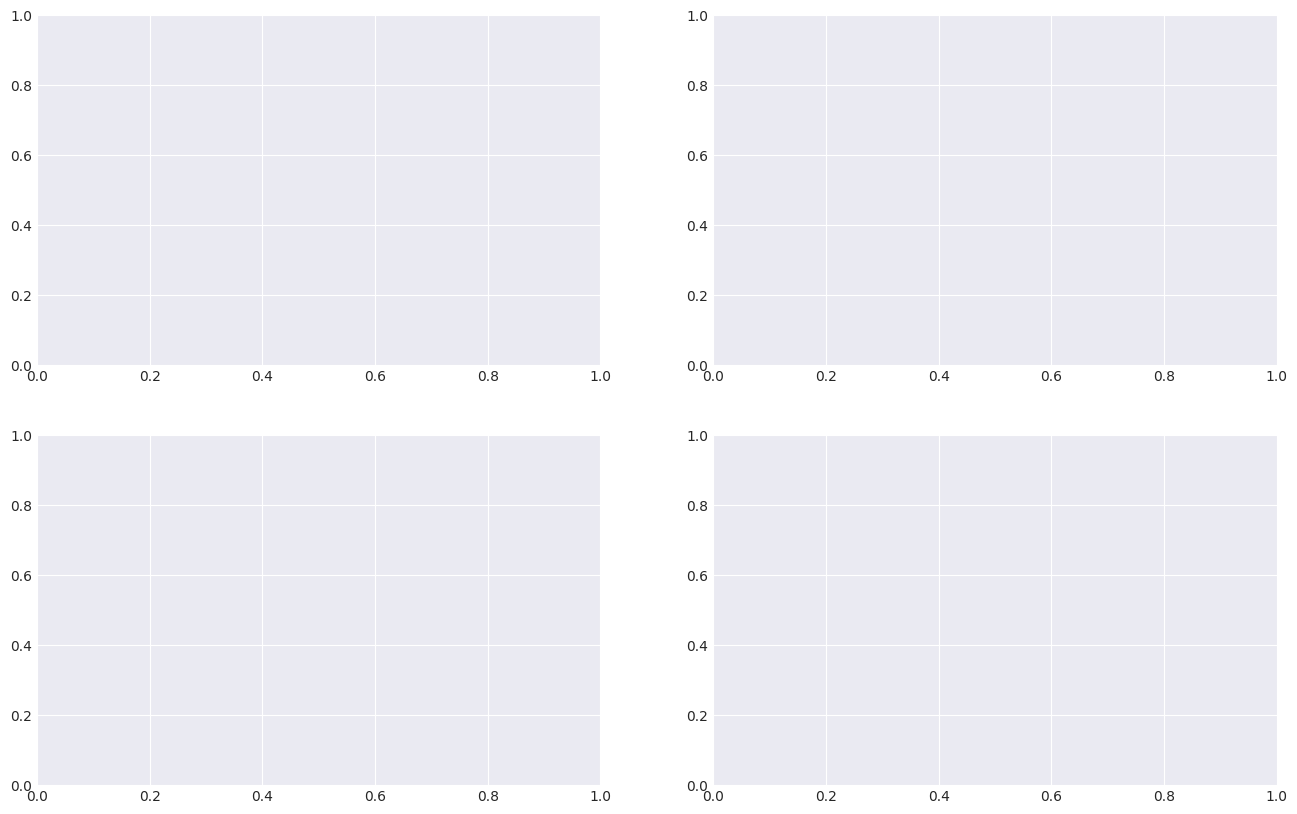

In [13]:
# Plot time series
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'{example_stock} - Fundamental Trends Over Time', fontsize=16, fontweight='bold')

# Revenue
axes[0, 0].plot(stock_history['Date'], stock_history['Revenue'] / 1e9, marker='o', linewidth=2, markersize=8)
axes[0, 0].set_title('Quarterly Revenue', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Revenue (Billions $)', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# EPS
axes[0, 1].plot(stock_history['Date'], stock_history['EPS'], marker='o', linewidth=2, markersize=8, color='green')
axes[0, 1].set_title('Earnings Per Share (EPS)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('EPS ($)', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# ROE
axes[1, 0].plot(stock_history['Date'], stock_history['ROE'], marker='o', linewidth=2, markersize=8, color='orange')
axes[1, 0].set_title('Return on Equity (ROE)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('ROE (%)', fontsize=10)
axes[1, 0].axhline(y=10, color='red', linestyle='--', alpha=0.5, label='Target: 10%')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# P/E Ratio
axes[1, 1].plot(stock_history['Date'], stock_history['PERatio'], marker='o', linewidth=2, markersize=8, color='purple')
axes[1, 1].set_title('P/E Ratio', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('P/E Ratio', fontsize=10)
axes[1, 1].axhline(y=30, color='red', linestyle='--', alpha=0.5, label='Target: < 30')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.subplots_adjust(left=0.08, right=0.95, top=0.92, bottom=0.08, hspace=0.3, wspace=0.25)
plt.show()

print(f"\n{example_stock} Trend Analysis:")
print("  - Look for consistent growth in Revenue and EPS")
print("  - Stable/improving ROE indicates efficient operations")
print("  - P/E ratio shows market valuation relative to earnings")

---

## Part 8: Integration with Backtesting

Now let's see how to use the custom fundamental data in a real Zipline backtest with the Sharadar bundle for pricing data.

### Pipeline Definition with Bundle Integration

The key is to create a pipeline that combines:
1. **Fundamental data** from our custom database
2. **Pricing data** from the Sharadar bundle
3. **Screening logic** based on both

In [ ]:
# Define a pipeline that combines fundamental and price datafrom zipline.pipeline import Pipelinefrom zipline.pipeline.data import EquityPricingdef make_quality_pipeline():    """    Pipeline combining custom fundamentals with bundle pricing data.        Returns:        Pipeline with quality stocks based on fundamental + technical screens    """    # ========================================================================    # FUNDAMENTAL DATA (from custom database)    # ========================================================================        # Get fundamental metrics    roe = CustomFundamentals.ROE.latest    pe_ratio = CustomFundamentals.PERatio.latest    debt_to_equity = CustomFundamentals.DebtToEquity.latest    eps = CustomFundamentals.EPS.latest    current_ratio = CustomFundamentals.CurrentRatio.latest    sector = CustomFundamentals.Sector.latest        # Calculate quality score    quality_score = QualityScore()        # Calculate profit margin    profit_margin = ProfitMargin()        # ========================================================================    # PRICING DATA (from sharadar bundle)    # ========================================================================        # Get price and volume from bundle    close_price = EquityPricing.close.latest    volume = EquityPricing.volume.latest        # Calculate technical indicators    avg_volume_20d = EquityPricing.volume.mavg(20)  # 20-day average volume        # ========================================================================    # SCREENING LOGIC    # ========================================================================        # Fundamental quality filters    high_roe = (roe > 5.0)  # Profitable    reasonable_pe = (pe_ratio < 50.0)  # Not overvalued    manageable_debt = (debt_to_equity < 5.0)  # Not over-leveraged        # Liquidity filters (from pricing data)    liquid = (avg_volume_20d > 100000)  # Minimum liquidity    valid_price = (close_price > 1.0)  # Minimum price        # Combined universe    quality_universe = (        high_roe &        reasonable_pe &        manageable_debt &        liquid &        valid_price    )        # Rank stocks by quality score    quality_rank = quality_score.rank(mask=quality_universe, ascending=False)        # ========================================================================    # RETURN PIPELINE    # ========================================================================        return Pipeline(        columns={            # Fundamental metrics            'quality_score': quality_score,            'quality_rank': quality_rank,            'roe': roe,            'pe_ratio': pe_ratio,            'debt_to_equity': debt_to_equity,            'eps': eps,            'current_ratio': current_ratio,            'profit_margin': profit_margin,            'sector': sector,                        # Pricing metrics            'close': close_price,            'volume': volume,            'avg_volume_20d': avg_volume_20d,        },        screen=quality_universe,    )# Create the pipelinequality_pipeline = make_quality_pipeline()print("✓ Quality pipeline created with fundamental + pricing data")print("\nPipeline combines:")print("  - Fundamental data: ROE, P/E, Debt/Equity, EPS, etc. (custom database)")print("  - Pricing data: Close, Volume, Moving averages (sharadar bundle)")print("  - Screening: Quality filters + liquidity requirements")

### Running a Backtest

I've created a complete backtest script for you: `backtest_with_fundamentals.py`

**Strategy Logic**:
1. Every month (or week), run the pipeline to get quality stocks
2. Select top N stocks by quality score
3. Equal-weight portfolio
4. Rebalance on schedule

**To run the backtest**:

```bash
cd examples/custom_data
python backtest_with_fundamentals.py
```

**To visualize results**:

```bash
python plot_backtest_results.py
```

Let me show you the key parts of the backtest code:

In [ ]:
# Example: Algorithm initialization
def initialize(context):
    """
    Called once at the start of the backtest.
    """
    # Attach our pipeline that combines fundamentals + pricing
    attach_pipeline(make_quality_pipeline(), 'quality_stocks')
    
    # Schedule monthly rebalancing
    schedule_function(
        rebalance,
        date_rules.month_start(),  # First trading day of month
        time_rules.market_open(hours=1),  # 1 hour after market open
    )
    
    # Set parameters
    context.top_n = 10  # Hold top 10 quality stocks
    
    print("✓ Algorithm initialized")
    print(f"  Strategy: Quality Factor (Fundamentals + Pricing)")
    print(f"  Top N stocks: {context.top_n}")
    print(f"  Rebalance: Monthly")

In [ ]:
# Example: Daily pipeline data retrieval
def before_trading_start(context, data):
    """
    Called every day before market open.
    Gets fresh pipeline data combining fundamentals and pricing.
    """
    # Get pipeline output
    context.output = pipeline_output('quality_stocks')
    
    # Pipeline output is a DataFrame with all stocks passing the screen
    # Columns include: quality_score, roe, pe_ratio, close, volume, etc.
    
    if len(context.output) > 0:
        avg_quality = context.output['quality_score'].mean()
        avg_roe = context.output['roe'].mean()
        
        print(f"{context.get_datetime().date()}")
        print(f"  Universe: {len(context.output)} stocks")
        print(f"  Avg Quality Score: {avg_quality:.3f}")
        print(f"  Avg ROE: {avg_roe:.1f}%")

In [12]:
# Example: Portfolio rebalancing
def rebalance(context, data):
    """
    Rebalance portfolio to hold top N quality stocks.
    """
    # Select top N stocks by quality rank (lowest rank = best quality)
    top_stocks = context.output.nsmallest(context.top_n, 'quality_rank')
    
    if len(top_stocks) == 0:
        return
    
    # Calculate equal weight
    target_weight = 1.0 / len(top_stocks)
    
    # Get current and target positions
    current_positions = set(context.portfolio.positions.keys())
    target_positions = set(top_stocks.index)
    
    # Sell stocks no longer in top N
    for asset in current_positions - target_positions:
        if data.can_trade(asset):
            order_target_percent(asset, 0.0)
            print(f"  SELL: {asset.symbol}")
    
    # Buy/rebalance top N stocks
    for asset in top_stocks.index:
        if data.can_trade(asset):
            order_target_percent(asset, target_weight)

            
            if asset not in current_positions:
                stock_data = top_stocks.loc[asset]
                print(f"  BUY: {asset.symbol} - "
                      f"Quality: {stock_data['quality_score']:.3f}, "
                      f"ROE: {stock_data['roe']:.1f}%, "
                      f"P/E: {stock_data['pe_ratio']:.1f}")

### Expected Output

When you run the backtest, you'll see:

```
BACKTEST CONFIGURATION
======================================================================
Strategy: Quality Factor (Fundamentals-based)
Top N stocks: 10
Rebalance: monthly
Period: 2023-04-01 to 2024-01-31
Initial capital: $100,000.00
======================================================================

2023-04-03
  Universe size: 8 stocks
  Avg Quality Score: 0.623
  Avg ROE: 12.3%
  Avg P/E: 35.2

  REBALANCING:
    Sell: 0 positions
    Buy: 8 positions
    Rebalance: 0 positions
    Target weight: 12.50%
      BUY:  AAPL (Score: 0.742, ROE: 36.9%, P/E: 29.2)
      BUY:  MSFT (Score: 0.698, ROE: 9.3%, P/E: 32.8)
      ...

BACKTEST RESULTS
======================================================================
Initial Capital: $100,000.00
Final Value:     $108,532.45
Total Return:    8.53%
Sharpe Ratio:    1.42
Max Drawdown:    -3.21%
Win Rate:        54.2%
Total Trades:    47
======================================================================
```

### Visualization Results

The `plot_backtest_results.py` script creates comprehensive charts:

1. **Portfolio Value**: Track growth over time
2. **Cumulative Returns**: See total performance
3. **Drawdown**: Understand risk/downside
4. **Returns Distribution**: Analyze return profile
5. **Monthly Heatmap**: See performance by month

All results are saved to:
- `backtest_results.csv` - Detailed daily data
- `backtest_performance.png` - Visualization charts

---

## Part 9: Troubleshooting & Tips

Common issues and solutions.

In [ ]:
print("""
TROUBLESHOOTING GUIDE
=====================

PROBLEM: "Database not found"
SOLUTION: Run the database creation cell (Part 1) first
   
PROBLEM: "No data returned from query"
SOLUTION: 
   - Check that data was loaded successfully (Part 2)
   - Verify your date range matches the data
   - Check that Sids exist in the database

PROBLEM: "Unmapped identifiers" warning
SOLUTION:
   - Add missing tickers to securities.csv
   - Or set fail_on_unmapped=False to skip them

PROBLEM: "Column not found" error
SOLUTION:
   - Verify column names match between CSV and schema
   - Check case sensitivity (Revenue vs revenue)
   - Run describe_custom_db() to see available columns

PROBLEM: Pipeline gives errors
SOLUTION:
   - Ensure dates are timezone-aware: pd.Timestamp('2023-01-01', tz='UTC')
   - Check that assets exist in both bundle AND custom data
   - Verify CustomSQLiteLoader is registered correctly

TIPS FOR BEST RESULTS:
======================

1. DATA QUALITY:
   - Clean your CSV data before loading
   - Handle missing values appropriately
   - Ensure dates are in consistent format

2. PERFORMANCE:
   - Use appropriate data types (int for large numbers, not float)
   - Index frequently-queried columns
   - Use date range filters in queries

3. DATA UPDATES:
   - Use on_duplicate='replace' to update existing records
   - Use on_duplicate='ignore' to skip duplicates
   - Use on_duplicate='fail' to catch data issues

4. FACTOR DESIGN:
   - Normalize factors to similar scales for combining
   - Handle missing data with .fillna() or filters
   - Test factors individually before combining

5. BACKTESTING:
   - Ensure point-in-time correctness (no look-ahead bias)
   - Match fundamental frequency (quarterly) with rebalancing
   - Consider reporting lag (fundamentals released ~45 days after quarter-end)

NEXT STEPS:
===========

1. Load your own fundamental data CSV
2. Create custom factors based on your research
3. Backtest strategies using fundamental signals
4. Combine with price/volume factors for multi-factor models
5. Analyze results and iterate

For more examples and documentation:
  - Zipline Custom Data: src/zipline/data/custom/README.md
  - Zipline Pipeline: https://zipline.ml4trading.io/pipeline.html
  - Example notebooks: examples/custom_data/
""")

---

## Summary

**What We Covered:**

1. ✅ Created a custom database for fundamental data
2. ✅ Loaded CSV data with symbol-to-sid mapping
3. ✅ Created Pipeline DataSets from custom data
4. ✅ Built screening pipelines (quality filters)
5. ✅ Created ranking pipelines (composite scores)
6. ✅ Performed sector analysis
7. ✅ Visualized fundamental metrics
8. ✅ Analyzed trends over time
9. ✅ Learned backtest integration

**Key Takeaways:**

- Custom data enables fundamental analysis in Zipline
- Pipeline makes it easy to screen and rank stocks
- Combine multiple factors for robust signals
- Visualizations help understand the data
- Integration with backtesting enables strategy development

**Next Steps:**

1. Try with your own fundamental data
2. Experiment with different factor combinations
3. Build and test investment strategies
4. Combine with technical indicators
5. Run full backtests and analyze performance

Happy researching! 📊🚀